In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
# Make sure we're in the right directory
if os.path.basename(os.getcwd()) == "notebooks":
    os.chdir("..")

In [ ]:
import xarray as xr
import numpy as np
from typing import *
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from aibedo.utilities.plotting import data_snapshots_plotting, data_mean_plotting
from aibedo.utilities.wandb_api import reload_checkpoint_from_wandb

In [ ]:
plt.rcParams['figure.figsize'] = [80, 15]  # general matplotlib parameters
plt.rcParams['figure.dpi'] = 120 

In [ ]:
num_workers = 2
test_set = "era5"
DATA_DIR = "./data"

overrides = [f'datamodule.num_workers={num_workers}',
             f'datamodule.partition={[0.85, 0.15, test_set]}',
             'datamodule.eval_batch_size=30',
             'verbose=False',
             f'datamodule.data_dir={DATA_DIR}'
            ]

In [6]:
cur_run_id = None
def get_model_and_dm_from_run_id(run_id):
    global cur_run_id
    cur_run_id = run_id
    values = reload_checkpoint_from_wandb(run_id=run_id, project='AIBEDO', override_key_value=overrides, try_local_recovery=False)
    return  values['model'], values['datamodule'], values['config']

In [7]:
def get_predictions_xarray(run_id, split='predict', return_normalized_outputs=False, variables='all'):
    model, dm, cfg = get_model_and_dm_from_run_id(run_id)
    print('physics_loss_weights:', cfg.model.physics_loss_weights)
    dm.setup(stage=split)
    dataloader = dm.val_dataloader() if 'val' in split else dm.predict_dataloader()
    predictions_xarray = dm.get_predictions_xarray(model, dataloader=dataloader, return_normalized_outputs=return_normalized_outputs, variables=variables)
    del model, dm, cfg
    return predictions_xarray

# Reload and predict with some models:
#### Baseline MLP, without any constraints

In [12]:
rid_baseline = "37z9auhs"
ds_mlp = get_predictions_xarray(rid_baseline)

physics_loss_weights: [0.0, 0.0, 0.0, 0.0, 0.0]


#### MLP with all constraints

*Note: the MLP with constraints likely does not have the best coefficients for the physics losses*

In [13]:
rid_all= "2ymsmghz"
ds_all_constraints_mlp = get_predictions_xarray(rid_all, split='predict')

physics_loss_weights: [0.0, 0.0, 100.0, 1.0, 0.0001]


#### MLP with 5th constraint (only) on

In [14]:
rid_c5_only = "3k486e3g"
ds_c5_mlp = get_predictions_xarray(rid_c5_only, split='predict')

physics_loss_weights: [0.0, 0.0, 0.0, 0.0, 0.0001]


In [15]:
snapshots = [1, 10, -50, -45, -38, -36]   # which timesteps to plot
pkwargs = dict(snapshots_to_plot=snapshots, same_colorbar_for_preds_and_targets=False, robust=False, marker_size=1, coastlines_linewidth=0.5)  # plotting kwargs

# Global maps


The predictions are for 6 arbitrary snapshots of the ERA5 test set
- First row: Targets 
- 2nd row: Predictions of MLP without constraints
- 3d row: Predictions of MLP with 5th constraint only
- 4d row: Predictions of MLP with all constraints

#### Surface pressure

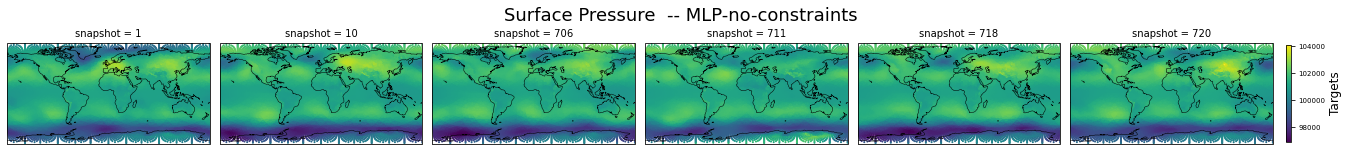

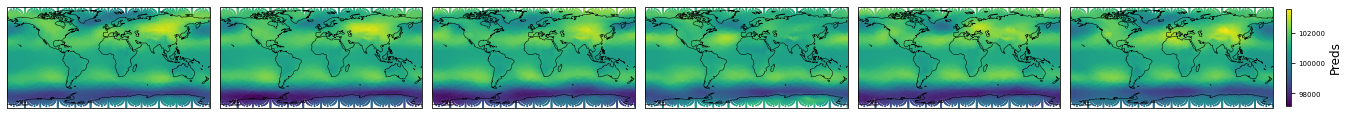

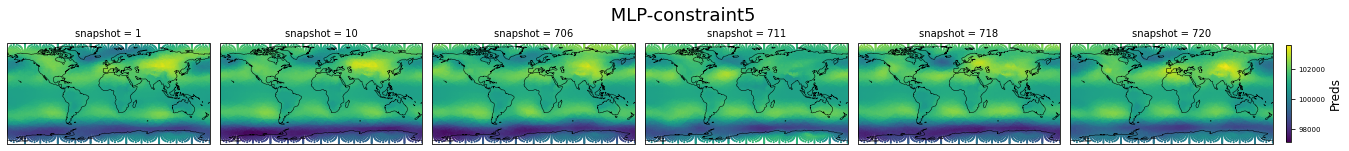

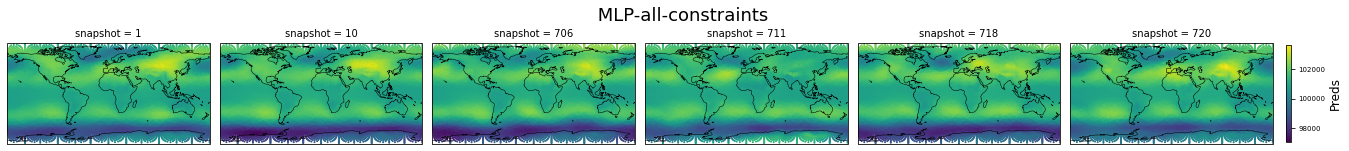

In [16]:
var= 'psl'
_ = data_snapshots_plotting(ds_mlp, title=" -- MLP-no-constraints", plot_error=False, cmap=None, **pkwargs, vars_to_plot=[var])
_ = data_snapshots_plotting(ds_c5_mlp, title=" MLP-constraint5", plot_only_preds=True, cmap=None, **pkwargs, vars_to_plot=[var])
_ = data_snapshots_plotting(ds_all_constraints_mlp, title=" MLP-all-constraints", plot_only_preds=True, cmap=None, **pkwargs, vars_to_plot=[var])

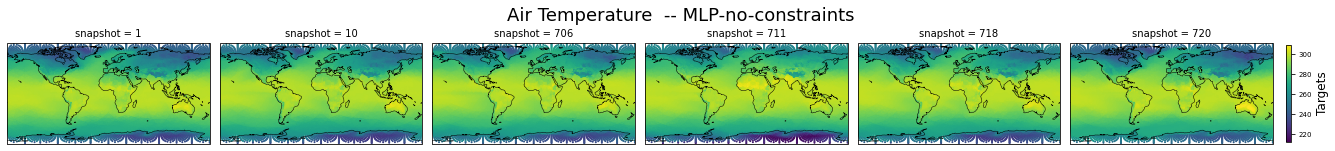

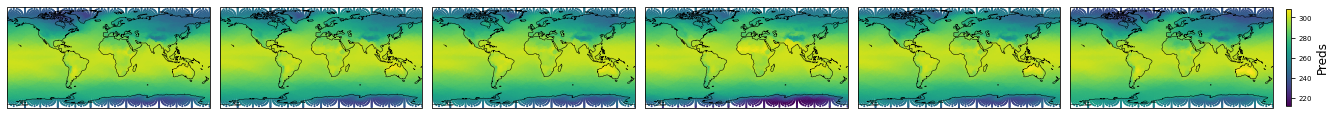

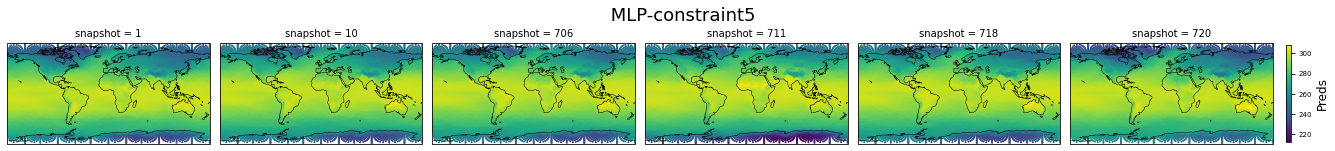

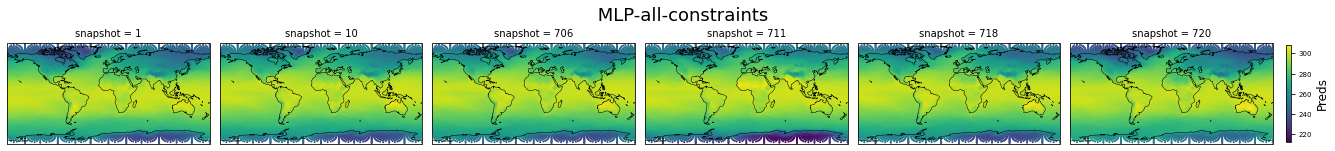

In [32]:
var= 'tas'
pkwargs['same_colorbar_for_preds_and_targets'] = False
_ = data_snapshots_plotting(ds_mlp, title=" -- MLP-no-constraints", plot_error=False, cmap=None, **pkwargs, vars_to_plot=[var])
_ = data_snapshots_plotting(ds_c5_mlp, title=" MLP-constraint5", plot_only_preds=True, cmap=None, **pkwargs, vars_to_plot=[var])
_ = data_snapshots_plotting(ds_all_constraints_mlp, title=" MLP-all-constraints", plot_only_preds=True, cmap=None, **pkwargs, vars_to_plot=[var])

## Plot errors
#### First, surface pressure

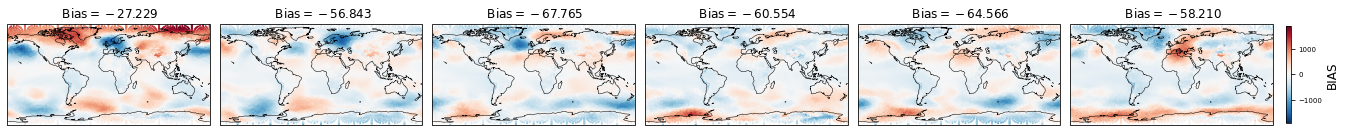

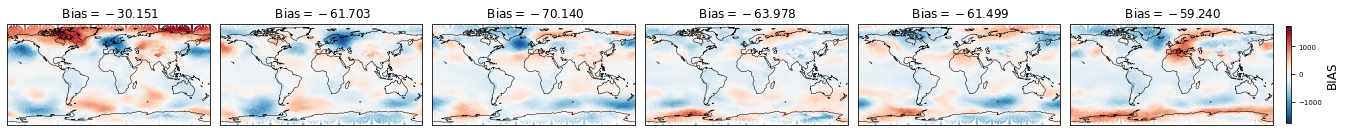

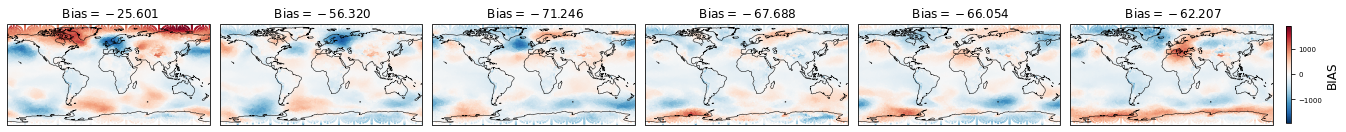

In [17]:
var= 'psl'
for ds in [ds_mlp, ds_c5_mlp, ds_all_constraints_mlp]:
    ds[f'{var}_bias'] = ds[f'{var}_preds'] - ds[f'{var}_targets']
pkwargs2 = {**pkwargs.copy(), **dict(vars_to_plot=[var], data_to_plot=['error'], error_to_plot='bias')}
_ = data_snapshots_plotting(ds_mlp, title=" -- MLP-no-constraints", cmap=None, **pkwargs2)
_ = data_snapshots_plotting(ds_c5_mlp, title=" MLP-constraint5", cmap=None, **pkwargs2)
_ = data_snapshots_plotting(ds_all_constraints_mlp, title=" MLP-all-constraints", cmap=None, **pkwargs2)

#### Temperature

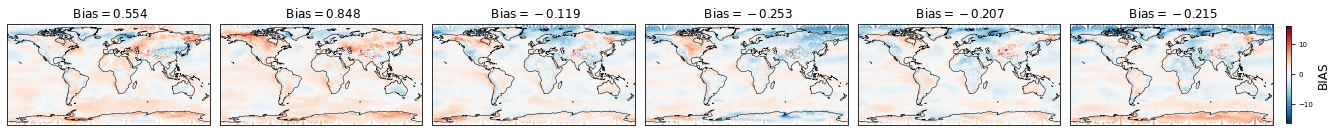

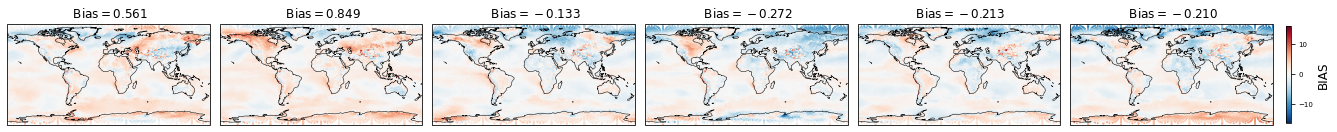

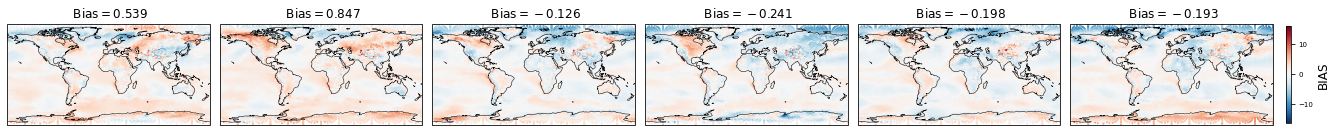

In [33]:
var= 'tas'
for ds in [ds_mlp, ds_c5_mlp, ds_all_constraints_mlp]:
    ds[f'{var}_bias'] = ds[f'{var}_preds'] - ds[f'{var}_targets']
pkwargs2 = {**pkwargs.copy(), **dict(vars_to_plot=[var], data_to_plot=['error'], error_to_plot='bias')}
_ = data_snapshots_plotting(ds_mlp, title=" -- MLP-no-constraints", cmap=None, **pkwargs2)
_ = data_snapshots_plotting(ds_c5_mlp, title=" MLP-constraint5", cmap=None, **pkwargs2)
_ = data_snapshots_plotting(ds_all_constraints_mlp, title=" MLP-all-constraints", cmap=None, **pkwargs2)